In [136]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
warnings.filterwarnings("ignore")
import FinanceDataReader as fdr

In [171]:
#sharpe지수를 maximize하는 포트폴리오 찾기

class portfolio:
    def __init__(self):
        self.train1 = pd.read_csv('./train.csv')
        self.train2 = pd.read_csv('./train_additional.csv')
        self.train = pd.concat([self.train1,self.train2])
        # self.train = pd.read_csv('./train.csv')
        self.train["일자"] = pd.to_datetime(self.train["일자"], format="%Y%m%d").dt.strftime("%Y-%m-%d")

    def get_data(self,start_date,end_date): #3개월
        # code_to_name = dict(zip(self.train["종목명"], self.train["종목코드"]))
        codes = self.train['종목코드'].unique()

        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        df = pd.DataFrame(index=date_range)

        for code in tqdm(codes):
            df_name = self.train[self.train['종목코드'].str.contains(code)]
            df_name["일자"] = pd.to_datetime(df_name["일자"])  

            df_name = df_name.groupby('일자')['종가'].mean()

            df_name = df_name[(df_name.index >= start_date) & (df_name.index <= end_date)]
            df[code] = df_name


        df = df.dropna()

        return df

    def get_sharape(self, df):
        codes = self.train['종목코드'].unique()
        daily_ret = df.pct_change() #일간 변동률 계산
        annual_ret = daily_ret.mean()*252 #242 곱해서 연간 수익률 구하기
        daily_cov = daily_ret.cov() #일간 리스크 (일간 변동률의 공분산)
        annual_cov = daily_cov*252 #연간리스크

        port_ret = []
        port_risk = []
        port_weights = []
        sharpe_ratio = []

        for _ in tqdm(range(100000)): #원하는 종목으로 구성된 포트폴리오 20000개 생성
            weights = np.random.random(len(codes))
            weights /= np.sum(weights) #총합이 1이 되도록 조정

            returns = np.dot(weights, annual_ret) #랜덤하게 생성한 종목별 비중 * 연간 수익률 => 포트폴리오 전체 수익률
            risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) #포트폴리오 전체 리스크

            port_ret.append(returns)
            port_risk.append(risk)
            port_weights.append(weights)
            sharpe_ratio.append(returns/risk)


        portfolio = {"Returns": port_ret, "Risk": port_risk, "Sharpe": sharpe_ratio}

        for i, s in enumerate(codes):
            portfolio[s] = [weight[i] for weight in port_weights]

        df_new = pd.DataFrame(portfolio)
        df_new = df_new[["Returns", "Risk", "Sharpe"] + [s for s in codes]]

        max_sharpe = df_new.loc[df_new['Sharpe'] == df_new['Sharpe'].max()]
        min_sharpe = df_new.loc[df_new['Sharpe'] == df_new['Sharpe'].min()]
        min_risk = df_new.loc[df_new['Risk'] == df_new['Risk'].min()]

        df_new.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='viridis', edgecolors='k', figsize = (11,7), grid = True)

        plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], c='r', marker="*", s=300)
        plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], c='r', marker="X", s=200)
        plt.scatter(x=min_sharpe['Risk'], y=min_sharpe['Returns'], c='r', marker="X", s=200)
        plt.xlabel("Risk")
        plt.ylabel("Expected Return")
        plt.show()

        max_sharpe_T = max_sharpe.T[3:]
        max_sharpe_T.columns=['순위']
        max_sharpe_T = max_sharpe_T.sort_values(by='순위',ascending=False)
        # max_sharpe_T = max_sharpe_T[:200]
        
        # min_sharpe_T = min_sharpe.T[3:]
        # # min_sharpe_T.columns=['비중']
        # min_sharpe_T = min_sharpe_T.sort_values(by='비중',ascending=False)
        # min_sharpe_T = min_sharpe_T[:200]

        # port = pd.concat([min_sharpe_T,max_sharpe_T])
        # port = pd.concat([max_sharpe_T[:200],max_sharpe_T[1800:]])
        max_sharpe_T.reset_index(inplace=True)
        max_sharpe_T.columns = ["종목명",'순위']

        return max_sharpe_T
    
    #특정 기간동안 상대 모멘텀에 투자했을 때의 평균 수익률 
    def get_abs_momentum(self, get_sharpe , start_date, end_date):
        stockList = list(get_sharpe['종목명'])
        name_to_code = dict(zip(self.train["종목명"], self.train["종목코드"]))
        rows=[]
        columns = ['code','company','old_price','new_price', 'returns']
        for name in tqdm(stockList):
            old_price = None
            new_price = None
            returns = None

            for index, row in self.train[self.train["종목코드"] == name].iterrows():
                if row["일자"] == start_date:
                    old_price = row["종가"]

                if row["일자"] == end_date:
                    new_price = row["종가"]

            returns = ((new_price / old_price) - 1) * 100
            code = name_to_code.get(name)

            rows.append([code, name, old_price, new_price, returns])

        df = pd.DataFrame(rows, columns=columns)
        df = df[['code', 'company', 'old_price', 'new_price', 'returns']]
        # df = df.sort_values(by='returns', ascending=False)
        df.index = pd.Index(range(2000))

        long =df[:200]['returns'].mean()
        short = df[1800:]['returns'].mean()

        print(df)
        # print(df['returns'].mean())
        print(long,short)
        print(long-short)

        # long_short = pd.concat([long,short])
        # merged_df = df.merge(long_short, on=['종목코드'], how='outer', indicator=True)
        # missing_in_longshort = merged_df[merged_df['_merge'] == 'left_only']

        # result = pd.concat([long,missing_in_longshort,short])
        submission = pd.DataFrame(df['company'])
        submission.columns=['종목코드']
        submission['순위']= range(1,len(submission)+1)
        submission.set_index('종목코드', inplace=True)

        return submission


In [174]:
portfolio = portfolio()

In [175]:
df = portfolio.get_data('2023-06-09', '2023-07-07')
df


100%|██████████| 2000/2000 [05:40<00:00,  5.87it/s]


,A060310,A095570,A006840,A054620,A265520,A211270,A027410,A282330,A126600,A138930,...,A243070,A084110,A145020,A024060,A010240,A189980,A000540,A003280,A037440,A238490
2023-06-09,2965.0,4415.0,18740.0,11050.0,21550.0,14260.0,4140.0,186100.0,6890.0,7010.0,...,32400.0,20400.0,106900.0,5700.0,6570.0,2980.0,3275.0,1449.0,9100.0,8110.0
2023-06-12,3075.0,4380.0,18230.0,10980.0,21350.0,14340.0,4115.0,186800.0,6500.0,6930.0,...,31900.0,20100.0,105100.0,5660.0,6570.0,2985.0,3320.0,1530.0,9110.0,8300.0
2023-06-13,3040.0,4390.0,18290.0,10870.0,21750.0,14250.0,4090.0,185700.0,6350.0,6920.0,...,31800.0,20200.0,104600.0,5650.0,6510.0,3005.0,3265.0,1496.0,9070.0,8170.0
2023-06-14,3000.0,4405.0,19170.0,10690.0,21500.0,13700.0,4090.0,188800.0,6170.0,6840.0,...,31600.0,20000.0,102400.0,5650.0,6440.0,2975.0,3210.0,1447.0,8900.0,7850.0
2023-06-15,3025.0,4415.0,18870.0,10720.0,21800.0,14000.0,4080.0,190400.0,6210.0,6850.0,...,30900.0,20200.0,101500.0,5610.0,6360.0,3025.0,3185.0,1420.0,8830.0,7810.0
2023-06-16,2960.0,4680.0,19590.0,10520.0,21750.0,14110.0,4030.0,193900.0,6210.0,6910.0,...,31150.0,20400.0,102500.0,5630.0,6710.0,3075.0,3185.0,1411.0,8910.0,8150.0
2023-06-19,3070.0,4630.0,19800.0,10390.0,21500.0,14300.0,3975.0,185700.0,6310.0,6910.0,...,31200.0,20700.0,101600.0,5610.0,6740.0,3060.0,3170.0,1451.0,9160.0,7980.0
2023-06-20,3005.0,4545.0,19680.0,10230.0,21450.0,14050.0,3970.0,187000.0,6150.0,6910.0,...,31450.0,20250.0,102000.0,5620.0,6680.0,3095.0,3170.0,1886.0,9180.0,7820.0
2023-06-21,2985.0,4550.0,19110.0,10040.0,21400.0,13800.0,3925.0,183900.0,6150.0,6890.0,...,31100.0,20650.0,101700.0,5550.0,6640.0,3105.0,3155.0,2115.0,9300.0,7660.0
2023-06-22,2940.0,4505.0,19710.0,9950.0,20800.0,13680.0,3925.0,182300.0,6190.0,6940.0,...,31100.0,20800.0,103700.0,5550.0,6700.0,3075.0,3120.0,2070.0,9180.0,7680.0


100%|██████████| 100000/100000 [07:17<00:00, 228.80it/s]


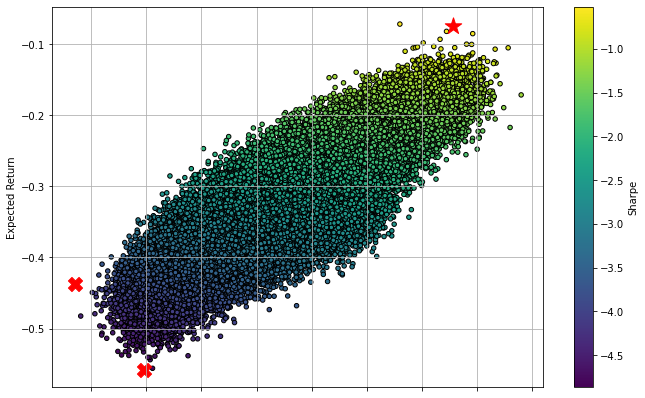

In [176]:
result_df= portfolio.get_sharape(df)

In [177]:
result_df

,종목명,순위
0,A005490,0.001013
1,A010820,0.001013
2,A261200,0.001012
3,A032860,0.001012
4,A003160,0.001012
...,...,...
1995,A103140,0.000004
1996,A000320,0.000003
1997,A336370,0.000002
1998,A002030,0.000002


In [178]:
result_1 = portfolio.get_abs_momentum(result_df,'2023-06-09', '2023-07-07')

100%|██████████| 2000/2000 [01:32<00:00, 21.56it/s]

      code  company  old_price  new_price    returns
0     None  A005490     394000     400000   1.522843
1     None  A010820       4645       4155 -10.548977
2     None  A261200      11700      11290  -3.504274
3     None  A032860       3640       3640   0.000000
4     None  A003160       7120       7610   6.882022
...    ...      ...        ...        ...        ...
1995  None  A103140      41500      40000  -3.614458
1996  None  A000320      10300      10250  -0.485437
1997  None  A336370      39850      37200  -6.649937
1998  None  A002030     138700     140200   1.081471
1999  None  A052220       3555       3275  -7.876231

[2000 rows x 5 columns]
10.31582521986582 -5.438264904363385
15.754090124229204


In [180]:
result_1

,순위
종목코드,
A005490,1
A010820,2
A261200,3
A032860,4
A003160,5
...,...
A103140,1996
A000320,1997
A336370,1998


In [179]:
result_df['순위'] = result_df['순위'].rank(ascending=False, method='first').astype(int)
# result_df.set_index('종목코드', inplace=True)

result_df.to_csv('b.csv')
result_df

,종목명,순위
0,A005490,1
1,A010820,2
2,A261200,3
3,A032860,4
4,A003160,5
...,...,...
1995,A103140,1996
1996,A000320,1997
1997,A336370,1998
1998,A002030,1999
